# XNLI

### Compute Variance, Entropy, Mean Accuracy, Consistency, and Confusion matrix(by majority vote) per Language for XNLI Predictions
### Languages: ['en', 'el', 'bg', 'es', 'fr', 'th']


In [8]:
import os
import json
import numpy as np
import datetime
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from scipy.stats import entropy, mode

root_dir = '../xnli/raw_results/google/original'
language_order = ['en', 'el', 'bg', 'es', 'fr', 'th']
num_runs = 25
num_classes = 3

language_predictions = defaultdict(list)
language_true_labels = {}
language_accuracies = {}
language_consistency = {}
language_variances = {}
language_entropies = {}
language_confusion_matrices = {}


# Load Predictions + True Labels 
for run_num in range(1, num_runs + 1):
    run_folder = os.path.join(root_dir, f"run ({run_num})", "Pipeline", "output", "predicted")
    for i, lang in enumerate(language_order):
        filename = "predicted.json" if i == 0 else f"predicted_{i}.json"
        json_file = os.path.join(run_folder, filename)
        if not os.path.exists(json_file):
            continue
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Replace None with -1 so they can be handled numerically
            preds = np.array([p if p is not None else -1 for p in data['predicted']]).flatten()
            trues = np.array(data['true']).flatten()
            language_predictions[lang].append(preds)
            if run_num == 1:
                language_true_labels[lang] = trues

# Analysis
def prediction_entropy(pred_list):
    counts = np.bincount(pred_list, minlength=num_classes)
    probs = counts / np.sum(counts)
    return entropy(probs, base=2)

for lang in language_order:
    preds_runs = np.array(language_predictions[lang])  # (runs, samples)

    # Replace placeholder -1s for invalid values
    preds_runs = np.where(preds_runs == -1, np.nan, preds_runs)

    transposed = preds_runs.T  # (samples, runs)
    true_labels = language_true_labels[lang]

    # Variance (ignore NaNs)
    language_variances[lang] = np.nanvar(transposed, axis=1)

    # Entropy
    entropies = []
    for sample in transposed:
        sample_clean = sample[~np.isnan(sample)].astype(int)
        entropies.append(prediction_entropy(sample_clean))
    language_entropies[lang] = np.array(entropies)

    # Accuracy (ignore positions with NaNs)
    accs = []
    for run in preds_runs:
        mask = ~np.isnan(run)
        accs.append(np.mean(run[mask] == true_labels[mask]))
    language_accuracies[lang] = np.mean(accs)

    # Consistency (ignore -1)
    filled = np.nan_to_num(transposed, nan=-1).astype(int)
    most_common = mode(filled, axis=1, keepdims=True)[0].flatten()
    consistency = np.mean([
        np.mean((sample == most_common[i]) & (sample != -1))
        for i, sample in enumerate(filled)
    ])
    language_consistency[lang] = consistency

    # Confusion matrix
    # Majority vote over the runs (ignoring NaNs)
    majority_preds = []
    for preds_per_sample in transposed:
        preds_clean = preds_per_sample[~np.isnan(preds_per_sample)].astype(int)
        if len(preds_clean) == 0:
            majority_preds.append(-1)  # fallback
        else:
            most_common = mode(preds_clean, keepdims=False).mode
            majority_preds.append(most_common if most_common.size == 1 else most_common[0])
    
    majority_preds = np.array(majority_preds)
    
    # Filter out samples with invalid predictions
    valid_mask = majority_preds != -1
    y_true = true_labels[valid_mask]
    y_pred = majority_preds[valid_mask]
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    language_confusion_matrices[lang] = cm.tolist()

# Save
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join("..", "xnli", "analysis", timestamp)
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "summary.txt"), "w") as f:
    f.write("Language\tVariance\tEntropy\tAccuracy\tConsistency\n")
    for lang in language_order:
        f.write(f"{lang}\t{np.mean(language_variances[lang]):.4f}\t{np.mean(language_entropies[lang]):.4f}"
                f"\t{language_accuracies[lang]:.4f}\t{language_consistency[lang]:.4f}\n")

with open(os.path.join(output_dir, "confusion_matrices.json"), "w") as f:
    json.dump(language_confusion_matrices, f, indent=2)

print(f"Metrics stored in {output_dir}")


Metrics stored in ..\xnli\analysis\20250420_143718


###  Bar Plot for Metrics

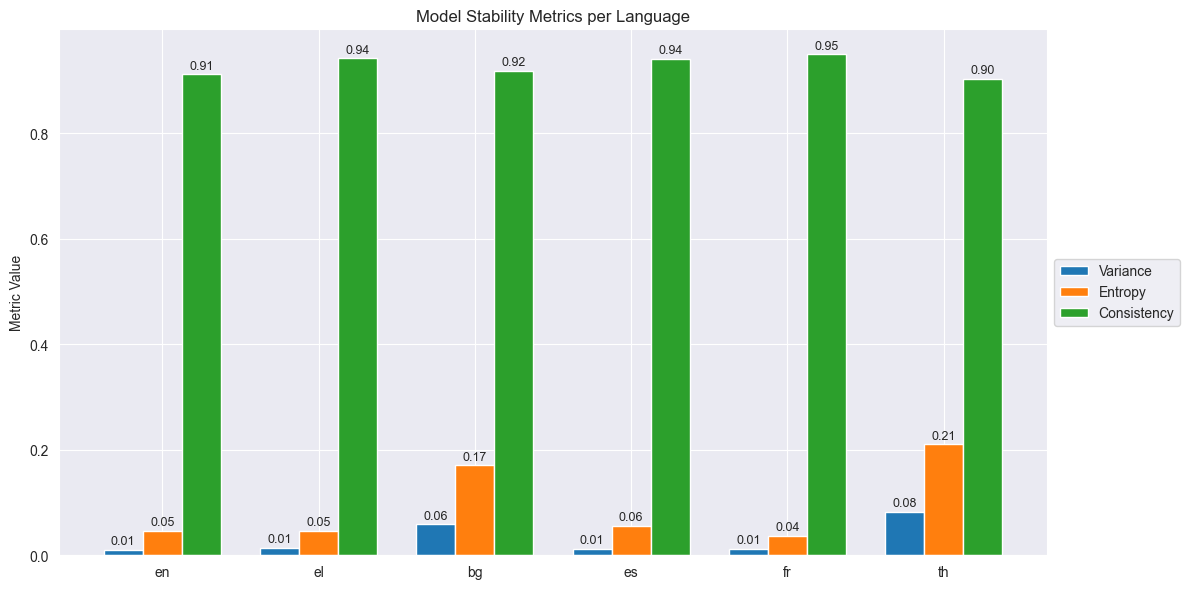

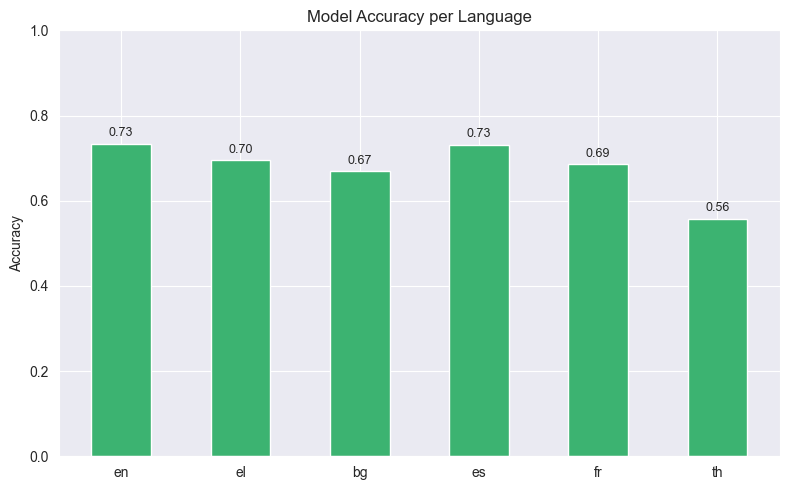

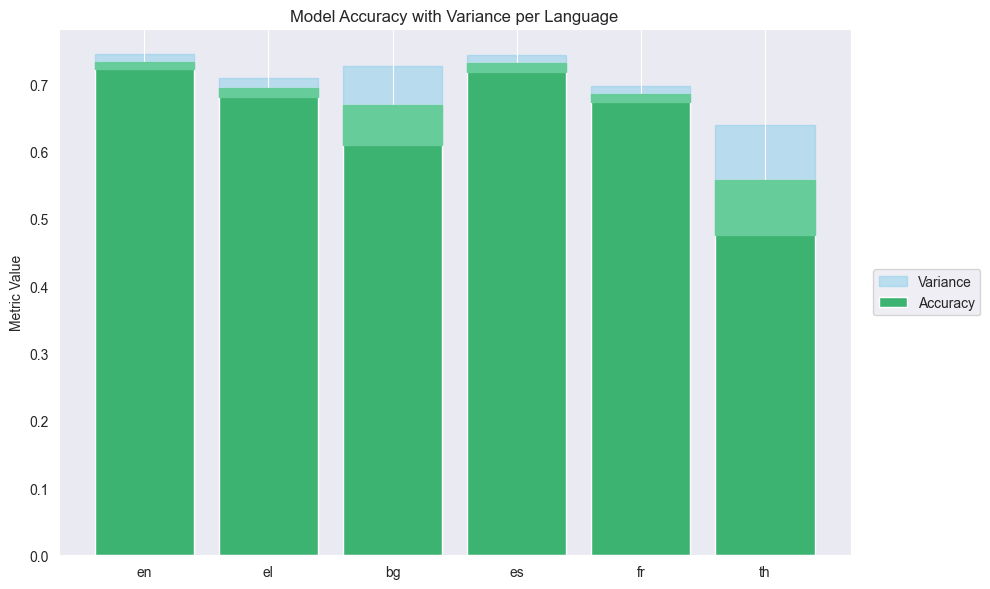

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

langs = language_order
variance_vals = [np.mean(language_variances[lang]) for lang in langs]
entropy_vals = [np.mean(language_entropies[lang]) for lang in langs]
accuracy_vals = [language_accuracies[lang] for lang in langs]
consistency_vals = [language_consistency[lang] for lang in langs]

x = np.arange(len(langs))
width = 0.25

# First Plot: Variance, Entropy, Consistency 
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width, variance_vals, width, label='Variance')
bars2 = plt.bar(x, entropy_vals, width, label='Entropy')
bars3 = plt.bar(x + width, consistency_vals, width, label='Consistency')

# Add value labels on top
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.005, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, langs)
plt.ylabel("Metric Value")
plt.title("Model Stability Metrics per Language")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Second Plot: Accuracy
plt.figure(figsize=(8, 5))
bars = plt.bar(langs, accuracy_vals, width=0.5, color='mediumseagreen')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy per Language")
plt.tight_layout()
plt.show()


# Third Plot: Variance over Accuracy
# Colors
mean_color = to_rgba('mediumseagreen')  # Accuracy bars
variance_color = to_rgba('skyblue', alpha=0.5)
blended_color = to_rgba((0.4, 0.8, 0.6, 1.0))  # blend of green and blue

# Plot
plt.figure(figsize=(10, 6))

# Draw bars (accuracy)
bars = plt.bar(x, accuracy_vals, color=mean_color, label='Accuracy')

# Draw variance regions and blended overlaps
for i, (acc, var) in enumerate(zip(accuracy_vals, variance_vals)):
    # Variance area
    plt.gca().add_patch(
        Rectangle(
            (i - 0.4, acc - var), 0.8, 2 * var,
            color=variance_color, zorder=0, label='Variance' if i == 0 else ""
        )
    )
    # Blended overlap
    plt.gca().add_patch(
        Rectangle(
            (i - 0.4, acc - var), 0.8, min(2 * var, var),
            color=blended_color, zorder=1
        )
    )

# Styling
plt.xticks(x, langs)
plt.ylabel("Metric Value")
plt.title("Model Accuracy with Variance per Language")
plt.grid(axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


### Label Distribution Comparison (Predicted vs True)

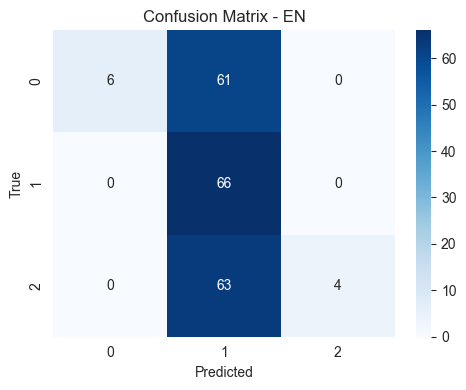

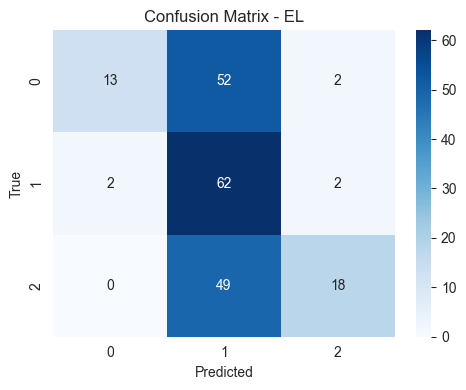

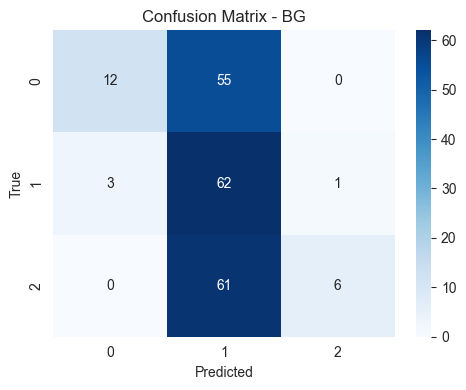

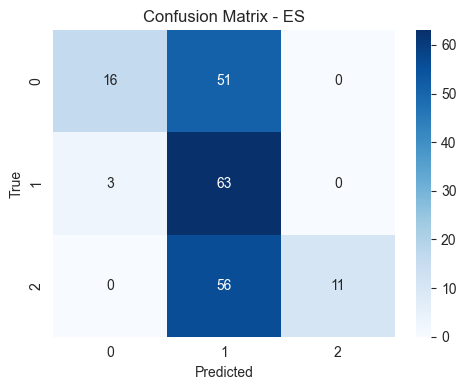

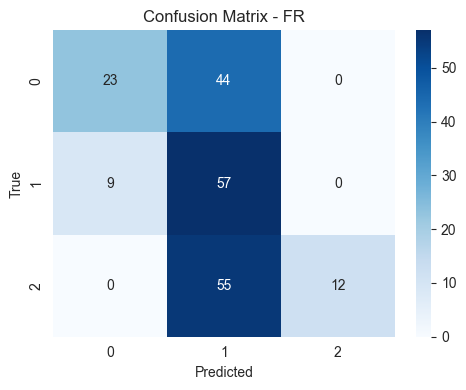

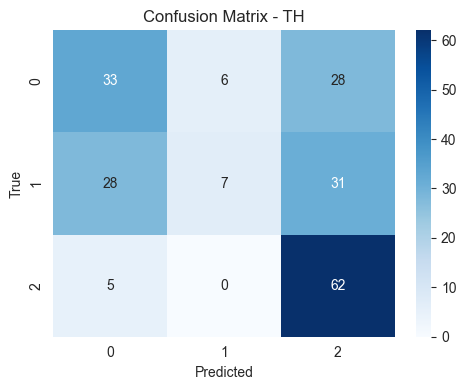

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, lang, labels):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {lang.upper()}")
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all languages
for lang in language_order:
    cm = language_confusion_matrices.get(lang)
    if cm is not None:
        plot_confusion_matrix(cm, lang, labels=[0, 1, 2])


# EUROPA

### Compute Mean LLM Judge Score and Variance in Scores|


Analysis saved to ../europa_random_split/analysis\analysis_20250504_181917.txt


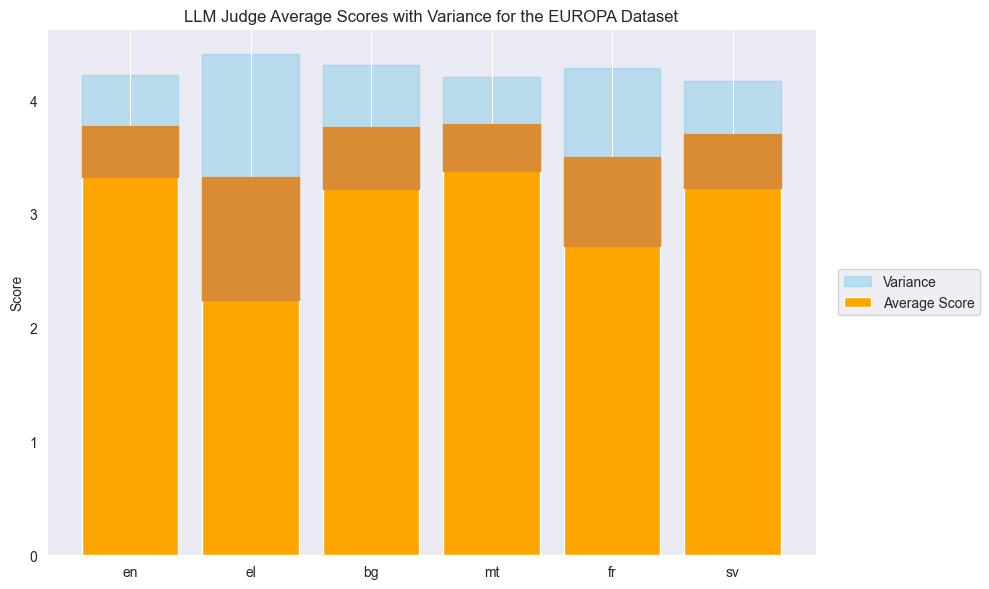

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

# Load file
file_path = "../europa_random_split/raw_results/judge_responses.txt"
with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()

# Parse language blocks
language_blocks = re.findall(r"==============Language: (\w+)=+.*?Parsed Numeric Scores:\n(.*?)(?=\n=|$)", content, re.DOTALL)

languages = []
means = []
variances = []

for lang, scores_str in language_blocks:
    scores = list(map(float, re.findall(r"\d+\.\d+", scores_str)))
    languages.append(lang)
    means.append(np.mean(scores))
    variances.append(np.var(scores))

# Plot
x = np.arange(len(languages))


mean_color = to_rgba('orange')
variance_color = to_rgba('skyblue', alpha=0.5)
blended_color = to_rgba((0.85, 0.55, 0.2, 1.0))  # blend of orange and skyblue

plt.figure(figsize=(10, 6))

# Draw bars (means)
bars = plt.bar(x, means, color=mean_color, label='Average Score')

# Draw variance regions and blended overlaps
for i, (mean, var) in enumerate(zip(means, variances)):
    # Variance area
    plt.gca().add_patch(
        Rectangle(
            (i - 0.4, mean - var), 0.8, 2 * var,
            color=variance_color, zorder=0, label='Variance' if i == 0 else ""
        )
    )
    # Overlap blend
    plt.gca().add_patch(
        Rectangle(
            (i - 0.4, mean - var), 0.8, min(2 * var, var),
            color=blended_color, zorder=1
        )
    )

# Ensure the output directory exists
output_dir = "../europa_random_split/analysis"
os.makedirs(output_dir, exist_ok=True)

# Create timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_dir, f"analysis_{timestamp}.txt")

# Write results to file
with open(output_path, "w", encoding="utf-8") as out_file:
    out_file.write("Language\tMean Score\tVariance\n")
    for lang, mean, var in zip(languages, means, variances):
        out_file.write(f"{lang}\t{mean:.4f}\t{var:.4f}\n")

print(f"Analysis saved to {output_path}")

# Styling
plt.xticks(x, languages)
plt.ylabel("Score")
plt.title("LLM Judge Average Scores with Variance for the EUROPA Dataset")
plt.grid(axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


# XQUAD

### Compute Mean LLM Judge, BLEU, METEOR, Cosine Similarity Scores and Variances in each Score

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from datetime import datetime

# Config
OUTPUT_DIR = "../xquad/analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = "../xquad/raw_results/google/attack_14"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_CSV = os.path.join(OUTPUT_DIR, f"metrics_summary_{timestamp}.csv")

# Model
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
smoothing = SmoothingFunction().method1

# Files
lang_map = {
    "en": "predicted_en.json",
    "el": "predicted_el.json",
    "ar": "predicted_ar.json",
    "zh": "predicted_zh.json",
    "ru": "predicted_ru.json",
    "th": "predicted_th.json",
    "tr": "predicted_tr.json"
}

def load_predictions(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data["true"], data["predicted"]

def compute_metrics_for_language(lang, file_path):
    true_answers, predicted = load_predictions(file_path)
    bleu, meteor, cosine = [], [], []

    for ref_list, hyp in zip(true_answers, predicted):
        ref = ref_list[0] if ref_list else ""
        hyp = hyp.strip().lower() if hyp else ""
        ref = ref.strip().lower()

        if not hyp:
            bleu.append(0)
            meteor.append(0)
            cosine.append(0)
            continue

        try:
            bleu.append(sentence_bleu([word_tokenize(ref)], word_tokenize(hyp), smoothing_function=smoothing))
            meteor.append(meteor_score([word_tokenize(ref)], word_tokenize(hyp)))
        except:
            bleu.append(0)
            meteor.append(0)

        try:
            emb_ref = embedding_model.encode([ref])[0].reshape(1, -1)
            emb_hyp = embedding_model.encode([hyp])[0].reshape(1, -1)
            cosine.append(cosine_similarity(emb_ref, emb_hyp)[0][0])
        except:
            cosine.append(0)

    return {
        "Language": lang,
        "BLEU_Mean": np.mean(bleu),
        "BLEU_Var": np.var(bleu),
        "METEOR_Mean": np.mean(meteor),
        "METEOR_Var": np.var(meteor),
        "Cosine_Mean": np.mean(cosine),
        "Cosine_Var": np.var(cosine)
    }

def parse_judge_scores(judge_file):
    with open(judge_file, "r", encoding="utf-8") as f:
        content = f.read()
    blocks = re.findall(r"Language: (\w+).*?Parsed Numeric Scores:\n(.*?)(?=\n=|$)", content, re.DOTALL)
    results = []
    for lang, scores in blocks:
        vals = list(map(float, re.findall(r"\d+\.\d+", scores)))
        results.append({
            "Language": lang.strip(),
            "LLM_Judge_Mean": np.mean(vals),
            "LLM_Judge_Var": np.var(vals)
        })
    return pd.DataFrame(results)


metric_rows = []
for lang, fname in lang_map.items():
    path = os.path.join(DATA_DIR, fname)
    row = compute_metrics_for_language(lang, path)
    metric_rows.append(row)

metrics_df = pd.DataFrame(metric_rows)
judge_df = parse_judge_scores(os.path.join(DATA_DIR, "judge_responses.txt"))

final_df = pd.merge(metrics_df, judge_df, on="Language", how="left")
final_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved results to {OUTPUT_CSV}")



C:\Users\Gebruiker\Documents\GitHub\Legal-Multilingual-Evaluation-of-LLMs\interp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Saved results to ../xquad/analysis\metrics_summary_20250423_151200.csv


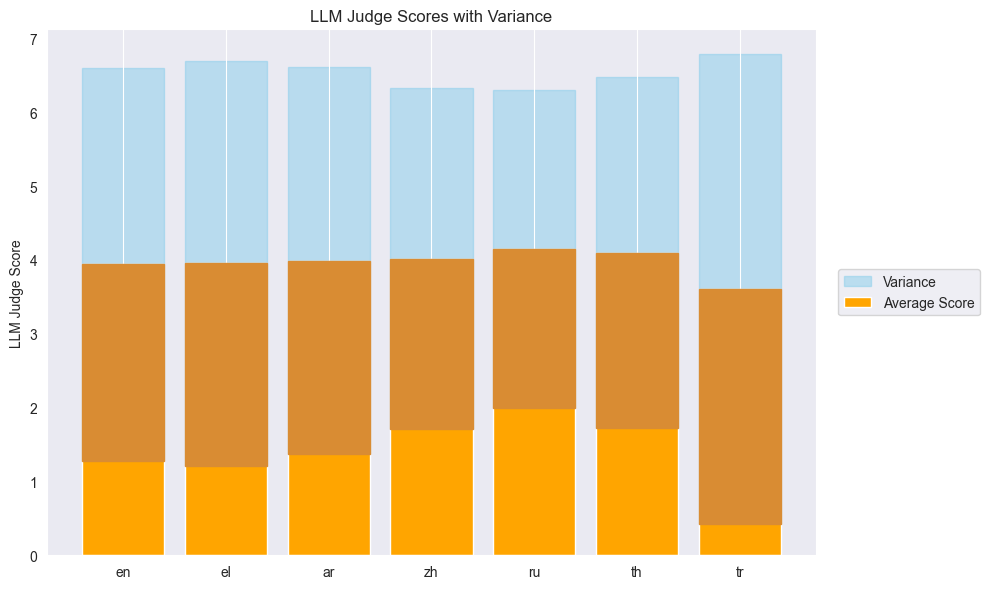

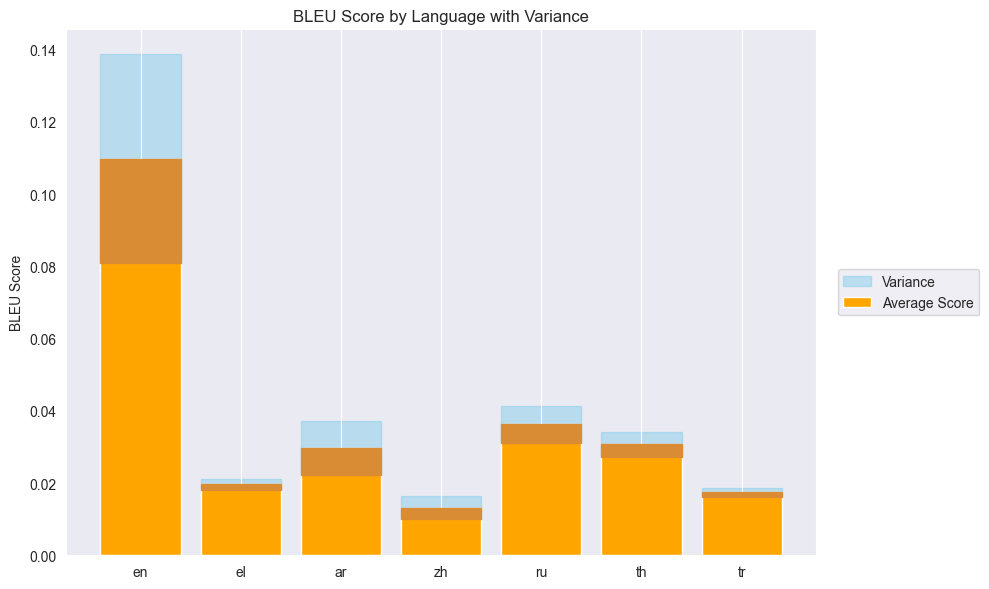

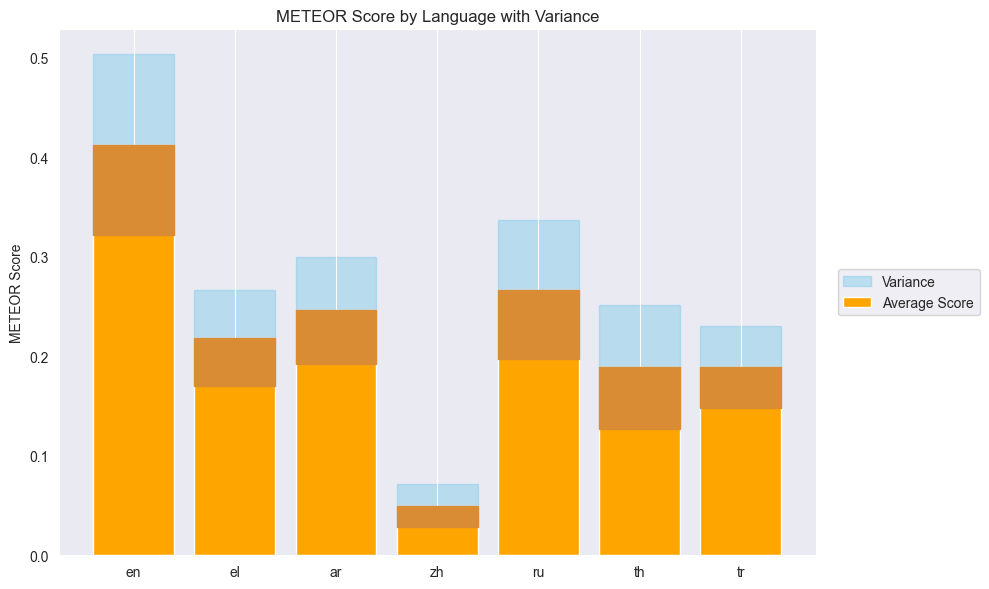

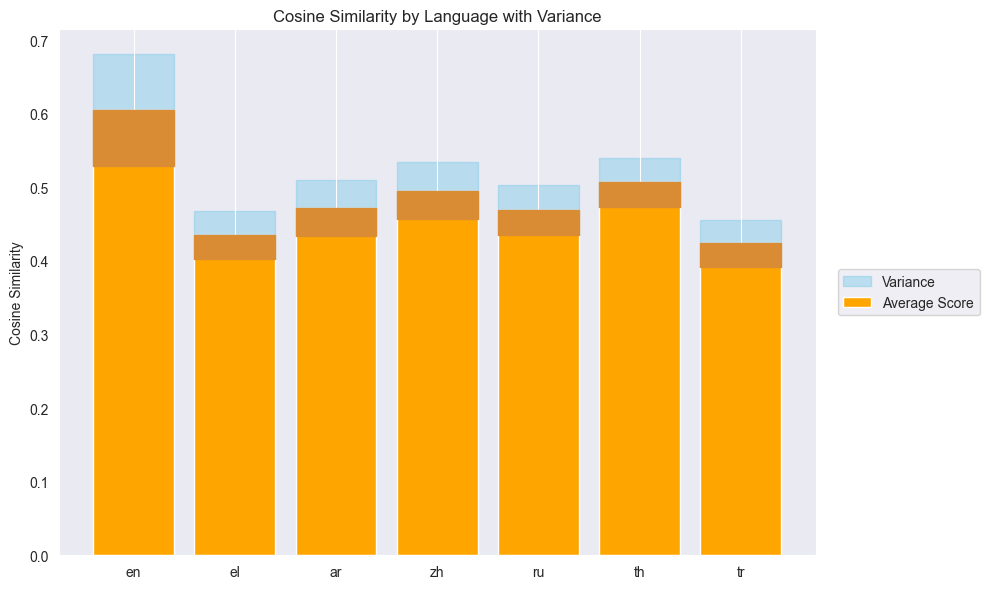

In [2]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

def plot_metric(df, mean_col, var_col, title, ylabel):
    languages = df["Language"]
    means = df[mean_col]
    variances = df[var_col]
    x = np.arange(len(languages))

    mean_color = to_rgba('orange')
    variance_color = to_rgba('skyblue', alpha=0.5)
    blended_color = to_rgba((0.85, 0.55, 0.2, 1.0))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, means, color=mean_color, label='Average Score')

    for i, (mean, var) in enumerate(zip(means, variances)):
        plt.gca().add_patch(
            Rectangle((i - 0.4, mean - var), 0.8, 2 * var,
                      color=variance_color, zorder=0,
                      label='Variance' if i == 0 else "")
        )
        plt.gca().add_patch(
            Rectangle((i - 0.4, mean - var), 0.8, min(2 * var, var),
                      color=blended_color, zorder=1)
        )

    plt.xticks(x, languages)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y')
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()


# Automatically select the latest CSV file
csv_files = glob.glob("../xquad/analysis/metrics_summary_*.csv")
latest_csv = max(csv_files, key=os.path.getctime)

df = pd.read_csv(latest_csv)

plot_metric(df, "LLM_Judge_Mean", "LLM_Judge_Var",
            "LLM Judge Scores with Variance", "LLM Judge Score")

plot_metric(df, "BLEU_Mean", "BLEU_Var",
            "BLEU Score by Language with Variance", "BLEU Score")

plot_metric(df, "METEOR_Mean", "METEOR_Var",
            "METEOR Score by Language with Variance", "METEOR Score")

plot_metric(df, "Cosine_Mean", "Cosine_Var",
            "Cosine Similarity by Language with Variance", "Cosine Similarity")
